In [154]:
from networkx.algorithms.bipartite import random_graph as bipartite_random_graph
from inputresolver import resolve, invert_edges, flatten_order, reassigneq
from representations import digraph_repr, draw_dsm

In [2]:
from random import Random, sample, randint
import random
import copy
import sympy as sp
import numpy as np
from functools import reduce
import networkx as nx

In [128]:
n_eqs = 10
n_vars = 13
seed = 8#seed 10 is nice
c = 1.1 #1.7
n_nodes = n_eqs + n_vars
p = n_nodes/(n_eqs*n_vars + 1.0e-17)*c
p = min(p, 1.0 - 1.0e-6) 
G = bipartite_random_graph(n_eqs, n_vars, p, seed)
#G = nx.bipartite.gnmk_random_graph(n_eqs, n_vars, int(0.2*n_vars*n_eqs), seed)

## Complete a potentially incomplete bipartite network
Create first a possible matching for all eqs, to make sure a matching is possible

In [129]:
eqs = list(range(n_eqs))
vrs = list(range(n_eqs, n_eqs+n_vars))

In [130]:
rng = np.random.default_rng(8)
M = dict(zip(rng.permutation(eqs), rng.permutation(vrs)))

In [131]:
for node in eqs:
    G.add_edge(node, M[node])

In [132]:
eqv = {elt: tuple(G[elt]) for elt in eqs}
varinc = {elt: tuple(G[elt]) for elt in vrs}
allowed = copy.deepcopy(eqv)

In [133]:
eqv

{0: (11, 19),
 1: (14, 15, 21, 22, 11),
 2: (11, 14),
 3: (10,),
 4: (18, 20, 12),
 5: (12, 15, 18, 22, 13),
 6: (10, 19, 20, 22, 17),
 7: (10, 12, 15),
 8: (13, 16, 17, 19, 18),
 9: (20,)}

In [134]:
edges = G.edges()

## Let's try to find a solution without cycles

In [151]:
#newdout = resolve(eqv, vrs, edges, maxiter=50, not_input=None)
#newdout = dict(newdout)

In [136]:
newdout

{0: 11, 1: 21, 2: 14, 3: 10, 4: 18, 5: 13, 6: 22, 7: 15, 8: 16, 9: 20}

In [137]:
def make_pure(eqv, dout):
    return {idx: (dout[idx], tuple(elt for elt in val if elt != dout[idx])) for idx,val in eqv.items()}

In [138]:
def default_in(eqlist, eqdictin=True):
    if eqdictin:
        eqlist = eqlist.values()
    ins = set()
    outvrs = set()
    for left, _ in eqlist:
        if left:
            outvrs = outvrs.union({left})
    for _, right in eqlist:
        ins = ins.union({elt for elt in right 
            if elt not in outvrs}) 
    return ins

In [139]:
D1, _ = digraph_repr(eqv, newdout)
C = nx.condensation(D1)
order = [C.nodes[n]['members'] for n in nx.topological_sort(C)]
print(order)

[{17}, {10}, {12}, {15}, {20}, {18}, {19}, {22}, {13}, {16}, {11}, {14}, {21}]


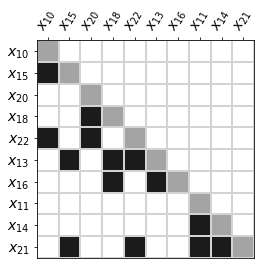

In [140]:
rlookup = {var:key for key,var in newdout.items()}
flattenorder = [rlookup[elt] for s in order for elt in s if elt in rlookup]
draw_dsm(D1, flattenorder, newdout, addvar=True);

In [141]:
eqsnew = make_pure(eqv, newdout)
default_in(eqsnew)

{12, 17, 19}

In [142]:
D2, _ = digraph_repr(eqv, M)
C = nx.condensation(D2)
order2 = [C.nodes[n]['members'] for n in nx.topological_sort(C)]
print(order2)

[{16}, {10}, {20}, {22}, {21}, {11, 12, 13, 14, 15, 17, 18, 19}]


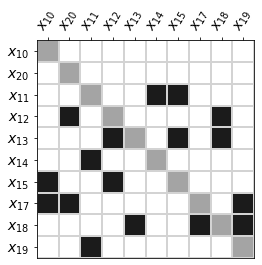

In [259]:
rlookup2 = {var:key for key,var in M.items()}
flattenorder2 = [rlookup2[elt] for s in order2 for elt in s if elt in rlookup2]
draw_dsm(D2, flattenorder2, M, addvar=True);

In [144]:
eqsold = make_pure(eqv, M)
default_in(eqsold)

{16, 21, 22}

# Generate eqs

In [145]:
rng = np.random.default_rng(12345)
smallrand = lambda n=1: np.round(rng.uniform(low=-1, high=1),n)
def gen_eqsdata(l):
    size = len(l)
    sall = []
    calcs = []
    for s in sample(l, size):
        q = {s}
        if q not in sall:
            sall.append(q)
            calcs.append((smallrand(), [s]))
    for elt in range(2,min(4,size+1)):
        s = sample(l, elt)
        if set(s) not in sall:
            sall.append(set(s))
            calcs.append((smallrand(), s))
    return calcs

def gen_speqs(eqs, sdict):
    calcs = gen_eqsdata(eqs)
    adder = smallrand()
    return sum([c*reduce(lambda a, b: a*sdict[b], [1]+r) for c,r in calcs])+adder

def gen_alleqs(eqv, sdict):
    return {idx: gen_speqs(vrs, sdict) for idx,vrs in eqv.items()}

In [146]:
sdict = {elt:sp.Symbol('x_{}'.format(elt)) for elt in vrs}

In [147]:
eqv

{0: (11, 19),
 1: (14, 15, 21, 22, 11),
 2: (11, 14),
 3: (10,),
 4: (18, 20, 12),
 5: (12, 15, 18, 22, 13),
 6: (10, 19, 20, 22, 17),
 7: (10, 12, 15),
 8: (13, 16, 17, 19, 18),
 9: (20,)}

In [148]:
seqs = gen_alleqs(eqv, sdict)

In [155]:
eqsnew

{0: (11, (19,)),
 1: (21, (14, 15, 22, 11)),
 2: (14, (11,)),
 3: (10, ()),
 4: (18, (20, 12)),
 5: (13, (12, 15, 18, 22)),
 6: (22, (10, 19, 20, 17)),
 7: (15, (10, 12)),
 8: (16, (13, 17, 19, 18)),
 9: (20, ())}

In [150]:
print('@var {}'.format(", ".join(['x_{}'.format(vr) for vr in vrs])))
print('@var λ[1:{}];'.format(n_eqs))
for key, var in seqs.items():
    print('h{}={};'.format(key, var))
print('vars=[{}]'.format(", ".join(['x_{}'.format(vr) for vr in vrs])))
print('dfdx=[{}]'.format(", ".join([str(0) if vr!=21 else 'x_{}'.format(vr) for vr in vrs])))
print('h=[{}];'.format(", ".join(['h{}'.format(eq) for eq in seqs.keys()])))

@var x_10, x_11, x_12, x_13, x_14, x_15, x_16, x_17, x_18, x_19, x_20, x_21, x_22
@var λ[1:10];
h0=0.6*x_11*x_19 - 0.5*x_11 - 0.4*x_19 + 0.4;
h1=-0.5*x_11*x_14*x_22 - 0.3*x_11 + 0.9*x_14*x_22 - 0.6*x_14 + 0.3*x_15 + 0.2*x_21 - 0.2*x_22 + 0.9;
h2=-0.1*x_11*x_14 + 0.3*x_11 - 0.8*x_14 + 0.8;
h3=0.4*x_10 - 0.3;
h4=-0.3*x_12*x_18*x_20 - 0.7*x_12*x_20 - 0.6*x_12 - 0.8*x_18 + 0.5*x_20 - 0.1;
h5=0.7*x_12*x_13*x_18 - 0.5*x_12 - 0.7*x_13 - 0.8*x_15 + 0.2*x_18*x_22 - 0.6*x_18 + 0.6*x_22 + 0.2;
h6=0.9*x_10*x_17 + 0.9*x_10 + 0.7*x_17 + 0.9*x_19 + 0.4*x_20 + 0.1*x_22 - 0.5;
h7=-0.5*x_10*x_12*x_15 - 0.1*x_10 + 0.8*x_12*x_15 + 0.3*x_12 - 0.3*x_15 - 0.3;
h8=0.2*x_13*x_16*x_18 - 0.3*x_13 - 0.9*x_16*x_19 - 0.4*x_16 + 0.3*x_17 - 1.0*x_18 - 0.5*x_19 - 0.6;
h9=-0.4*x_20 - 0.1;
vars=[x_10, x_11, x_12, x_13, x_14, x_15, x_16, x_17, x_18, x_19, x_20, x_21, x_22]
dfdx=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x_21, 0]
h=[h0, h1, h2, h3, h4, h5, h6, h7, h8, h9];


# Generate compute workflows
One where we have first set as input, and the other where we have second set as input with equality constraints (i.e. AAO/IDF) and one with MDF, although MDF might be really tricky

In [234]:
import openmdao.api as om
from notationcompute import optsolver, solver, explicit
from compute import buildidpvars, Expcomp, Evaluable

In [260]:
print(flattenorder2, order2)

[3, 9, 1, 4, 5, 2, 7, 6, 8, 0] [{16}, {10}, {20}, {22}, {21}, {11, 12, 13, 14, 15, 17, 18, 19}]


In [176]:
default_in(eqsold)

{16, 21, 22}

In [250]:
eqsfull = {idx: (sdict[eqsold[idx][0]], reassigneq(None, eq, sdict[eqsold[idx][0]])) for idx, eq in seqs.items()}


In [253]:
optin = {key:(None, val) for key,val in seqs.items()}
optin['f'] = (None, sdict[16]**2+sdict[21]**2)

In [254]:
def optsolver(groups, eqs, parentid, childid, solvevars, res):
    parent = groups[parentid]
    childid= 0
    child = groups[childid]# = parent.add_subsystem('group{}'.format(childid), 
        #om.Group(), promotes=['*'])
    for vr in solvevars:
        child.add_design_var(str(vr))
    ineqlts, eqlts, obj = res
    constraintnames = {
        'g{}'.format(childid): (ineqlts, {'upper':0.}),
        'h{}'.format(childid): (eqlts, {'upper':0., 'lower':0.}),
        'f{}'.format(childid): (obj, 'obj'),
    }
    for constraintname, (equations, bnd) in constraintnames.items():
        for eqn in equations:
            outname = constraintname+str(eqn)
            cmp = Expcomp(output_name=outname, equation=Evaluable.fromsympy(eqs[eqn][1]), debug=False)
            child.add_subsystem("eq{}".format(eqn), cmp, promotes=['*'])
            if bnd != 'obj':
                child.add_constraint('{}{}'.format(constraintname, eqn), **bnd)
            else:
                child.add_objective(outname)

In [255]:
prob = om.Problem()
model = prob.model
groups = {0:model}

In [256]:
solvefor = ['x_16', 'x_21', 'x_22', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_17', 'x_18', 'x_19']
scceqs = [1, 4, 5, 2, 7, 6, 8, 0]
buildidpvars(solvefor, model)
explicit(groups, eqsfull, 0, 'x_10', 3)
explicit(groups, eqsfull, 0, 'x_20', 9)
optsolver(groups, optin, 0, 1, solvefor, ([],scceqs,['f']))

In [257]:
prob.setup();

In [258]:
om.n2(model)

In [245]:
prob.set_solver_print(level=1)
prob.driver = om.ScipyOptimizeDriver()
prob.run_driver();

Optimization terminated successfully    (Exit mode 0)
            Current function value: [1.16658383e-09]
            Iterations: 9
            Function evaluations: 10
            Gradient evaluations: 9
Optimization Complete
-----------------------------------


In [246]:
model.list_outputs();

22 Explicit Output(s) in 'model'

varname  val              
-------  -----------------
inp
  x_16   [-2.89382005e-05]
  x_21   [-1.81428878e-05]
  x_22   [0.47946865]     
  x_11   [1.01782076]     
  x_12   [1.23297297]     
  x_13   [0.23958623]     
  x_14   [1.22573542]     
  x_15   [0.02280266]     
  x_17   [-0.42776117]    
  x_18   [-1.0586359]     
  x_19   [0.51691638]     
eq3
  x_10   [0.75]           
eq9
  x_20   [-0.25]          
eq1
  h01    [-3.0293279e-09] 
eq4
  h04    [-2.6117622e-10] 
eq5
  h05    [2.12592671e-09] 
eq2
  h02    [-2.4103608e-11] 
eq7
  h07    [-2.80375118e-09]
eq6
  h06    [0.]             
eq8
  h08    [2.8628383e-09]  
eq0
  h00    [7.36539274e-10] 
eqf
  f0f    [1.16658383e-09] 


0 Implicit Output(s) in 'model'




## Workflow 2

In [249]:
eqsfull2 = {idx: (sdict[eqsnew[idx][0]], reassigneq(None, eq, sdict[eqsnew[idx][0]])) for idx, eq in seqs.items()}

In [269]:
eqsfull2

{0: (x_11, 4.0*(x_19 - 1.0)/(6.0*x_19 - 5.0)),
 1: (x_21,
  2.5*x_11*x_14*x_22 + 1.5*x_11 - 4.5*x_14*x_22 + 3.0*x_14 - 1.5*x_15 + x_22 - 4.5),
 2: (x_14, (3.0*x_11 + 8.0)/(x_11 + 8.0)),
 3: (x_10, 0.750000000000000),
 4: (x_18, (-7.0*x_12*x_20 - 6.0*x_12 + 5.0*x_20 - 1.0)/(3.0*x_12*x_20 + 8.0)),
 5: (x_13,
  0.142857142857143*(5.0*x_12 + 8.0*x_15 - 2.0*x_18*x_22 + 6.0*x_18 - 6.0*x_22 - 2.0)/(x_12*x_18 - 1.0)),
 6: (x_22, -9.0*x_10*x_17 - 9.0*x_10 - 7.0*x_17 - 9.0*x_19 - 4.0*x_20 + 5.0),
 7: (x_15, (-x_10 + 3.0*x_12 - 3.0)/(5.0*x_10*x_12 - 8.0*x_12 + 3.0)),
 8: (x_16,
  (-3.0*x_13 + 3.0*x_17 - 10.0*x_18 - 5.0*x_19 - 6.0)/(-2.0*x_13*x_18 + 9.0*x_19 + 4.0)),
 9: (x_20, -0.250000000000000)}

In [261]:
flattenorder

[3, 7, 9, 4, 6, 5, 8, 0, 2, 1]

In [281]:
prob = om.Problem()
model = prob.model
groups = {0:model}

In [282]:
solvefor = ['x_12', 'x_17', 'x_19']
scceqs = [3, 7, 9, 4, 6, 5, 8, 0, 2, 1]
buildidpvars(solvefor, model)
for idx in scceqs:
    explicit(groups, eqsfull2, 0, eqsfull2[idx][0], idx)
optsolver(groups, optin, 0, 1, solvefor, ([],[],['f']))

In [283]:
prob.setup();

In [285]:
prob.set_solver_print(level=1)
prob.driver = om.ScipyOptimizeDriver()
prob.run_driver();

Optimization terminated successfully    (Exit mode 0)
            Current function value: [2.72715856e-07]
            Iterations: 22
            Function evaluations: 44
            Gradient evaluations: 22
Optimization Complete
-----------------------------------


In [286]:
model.list_outputs();

14 Explicit Output(s) in 'model'

varname  val             
-------  ----------------
inp
  x_12   [-7.08793947]   
  x_17   [2.55704489]    
  x_19   [-4.04718639]   
eq3
  x_10   [0.75]          
eq7
  x_15   [-0.7551628]    
eq9
  x_20   [-0.25]         
eq4
  x_18   [2.09325907]    
eq6
  x_22   [0.51531025]    
eq5
  x_13   [0.32627848]    
eq8
  x_16   [0.00012901]    
eq0
  x_11   [0.68943291]    
eq2
  x_14   [1.15868306]    
eq1
  x_21   [0.00050603]    
eqf
  f0f    [2.72715856e-07]


0 Implicit Output(s) in 'model'


